The aim of this notebook is to perform a quick test for an update of the model or a new optimization procedure.
To test a model update, each cell of this notebook must run with correct results.
To test a new optimization procedure, a new dedicated cell must be created on the same model as the previous ones.

As this pipeline consist in only one instance solved by each procedure once, it statisticaly has no meaning. For a statisticaly meaningful test pipeline, please run the Test pipeline notebook (heavily time consuming). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue_taylor.adjusters.adjust_annular import set_init_point, prepare_tensions, adjust_tensions
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale

Error: IPOPT shared library failed to import


### Control randomness

In [2]:
def get_sequence(seed, theta, shape):
    np.random.seed(seed)
    
    return np.random.normal(1.0, theta, shape)
seed = 1553

Generate the theoritical organoïd

In [3]:
organo = generate_ring(10, 110, 150)
Nf= organo.Nf
geom.update_all(organo)
normalize_scale(organo, geom)
#alpha as proposed in the doc (in french) https://www.sharelatex.com/read/zdxptpnrryhc
alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))


# Model parameters or specifications
specs = {
    'face':{
        'is_alive': 1,
        'prefered_area':  alpha*organo.face_df.area, 
        'area_elasticity': 1.,},
    'edge':{        
        'ux': 0.,
        'uy': 0.,
        'uz': 0.,
        'line_tension': 0.1,
        'is_active': 1
        },
    'vert':{
        'adhesion_strength': 0.,
        'x_ecm': 0.,
        'y_ecm': 0.,
        'is_active': 1
        },
    'settings': {
        'lumen_elasticity': 0.1,
        'lumen_prefered_vol': organo.settings['lumen_volume'],
        'lumen_volume': organo.settings['lumen_volume']
        }
    }

organo.update_specs(specs, reset=True)
geom.update_all(organo)

symetric_tensions = set_init_point(organo.settings['R_in'], organo.settings['R_out'], organo.Nf, alpha)
sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf, endpoint=False)))**2
organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
organo.edge_df.line_tension = prepare_tensions(organo, symetric_tensions)
organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul

organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]

organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01

new_tensions = organo.edge_df.line_tension

organo.edge_df.loc[:,'line_tension'] = new_tensions
                                                          
res = Solver.find_energy_min(organo, geom, model)                                                       

Reseting datasets values with new specs


Creating a printing function

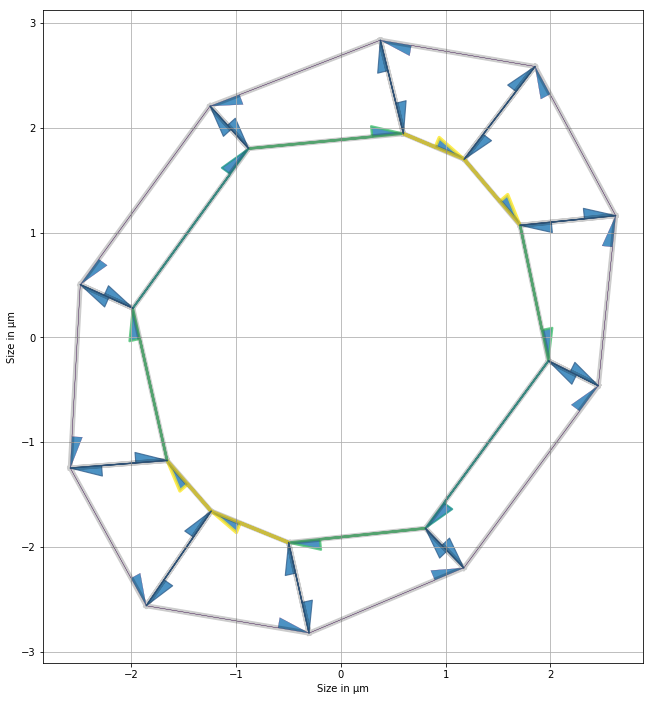

In [4]:
def print_tensions(exp_organo, th_organo):
    draw_specs = sheet_spec()
    tension_max = np.max(exp_organo.edge_df.line_tension.values.copy())
    edge_color = 1/tension_max*exp_organo.edge_df.line_tension.values.copy()
    cmap = plt.cm.get_cmap('viridis')
    edge_cmap = cmap(edge_color)
    draw_specs['vert']['visible'] = False
    draw_specs['edge']['color'] = edge_cmap
    draw_specs['edge']['width'] = 0.25+3*edge_color
    fig, ax = quick_edge_draw(th_organo, lw=5, c='k', alpha=0.2)
    fig, ax = sheet_view(exp_organo, ax=ax, **draw_specs)
    fig.set_size_inches(12, 12)
    plt.xlabel('Size in µm')
    plt.ylabel('Size in µm')
    
print_tensions(organo, organo)

Define the optimization parameters

In [5]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'L-BFGS-G','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(3*organo.Nf),[1000]*(3*organo.Nf)), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-4, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-8,'ftol': 1e-5, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'dist_PSQP', 'output_path': './PSQP_min_dist'}

reg_weight = 1e-3
theta = 0.02

# No change

We run our optimization process without any modification between the theoritical and experimental organoids to verify if it finds the same results.

{'norm_factor': 1, 'minimize': {'method': 'L-BFGS-B', 'options': {'disp': False, 'ftol': 1e-06, 'gtol': 0.001}}}
{'norm_factor': 1, 'minimize': {'method': 'L-BFGS-B', 'options': {'gtol': 1e-05, 'ftol': 1e-05}}}
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6278e-03                                    7.86e+02    
       1              2         1.0936e-03      5.34e-04       1.56e-03       6.00e+01    
       2              7         1.0413e-03      5.23e-05       6.26e-04       2.97e+01    
       3              8         1.0302e-03      1.11e-05       1.25e-03       3.85e+01    
       4              9         1.0236e-03      6.65e-06       3.13e-04       1.86e+01    
       5             11         1.0231e-03      5.02e-07       7.76e-05       9.56e+00    
       6             12         1.0229e-03      1.29e-07       7.63e-05       1.07e+01    
       7             13         1.0228e-03      1.60e-07     

/home/fquinton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


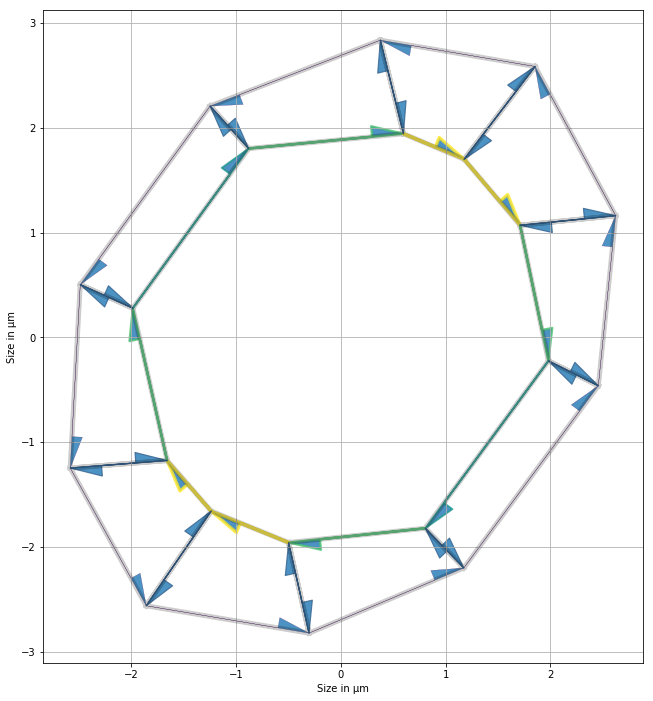

In [6]:
noisy = organo.copy()
initial_guess = organo.edge_df.line_tension[:3*organo.Nf].copy()
start = time.clock()
res = adjust_tensions(noisy, initial_guess, {'dic':{}, 'weight':0},
                      energy_opt, **trf_opt)
noisy_no_move = noisy.copy()
noisy_no_move.edge_df.line_tension = prepare_tensions(noisy_no_move,res.x)
Solver.find_energy_min(noisy_no_move, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(noisy_no_move, organo)

In [7]:
initial_guess = set_init_point(organo.settings['R_in'], organo.settings['R_out'], organo.Nf, alpha)

## PSQP energy minimization
This minimization procedure uses Preconditionned Sequential Quadratic Programming (PSQP) procedure from pyOpt to find the set of linear tensions that minimizes the energy in the experimental organoïd under constraint that 
$$||X_e-X_t||<\epsilon $$
Where $X_e$ (resp. $X_t$) is the set of euclidian coordinates of the vertices of the experimental (resp. theoritical) organoïd, and $\epsilon$ is the maximum distance allowed between the two. 
Initial point is computed with lm procedure.

It can be implemented with or without a regulzarization module that regularize the linear tensions of the apical or basal edges. 
It can be implemented with or without the lumen volume as an optimization parameter.

### Without regularization module nor lumen volume
Without the regularization module nor lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

Energy before optimization:  1.261425642969877
{'norm_factor': 1, 'minimize': {'method': 'L-BFGS-B', 'options': {'disp': False, 'ftol': 1e-06, 'gtol': 0.001}}}
{'norm_factor': 1, 'minimize': {'method': 'L-BFGS-B', 'options': {'gtol': 1e-05, 'ftol': 1e-05}}}
`ftol` termination condition is satisfied.
Function evaluations 852, initial cost 3.9063e+00, final cost 8.0095e-02, first-order optimality 5.86e+02.

Optimization Problem -- Distance minimization problem

        Objective Function: _wrap_obj_and_const

    Objectives:
        Name        Value        Optimum
	  distance           0             0

	Variables (c - continuous, i - integer, d - discrete):
        Name    Type       Value       Lower Bound  Upper Bound
	    L_0       c	      0.065550       0.00e+00     1.00e+06 
	    L_1       c	      0.089968       0.00e+00     1.00e+06 
	    L_2       c	      0.124785       0.00e+00     1.00e+06 
	    L_3       c	      0.120333       0.00e+00     1.00e+06 
	    L_4       c	      0.08

/home/fquinton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


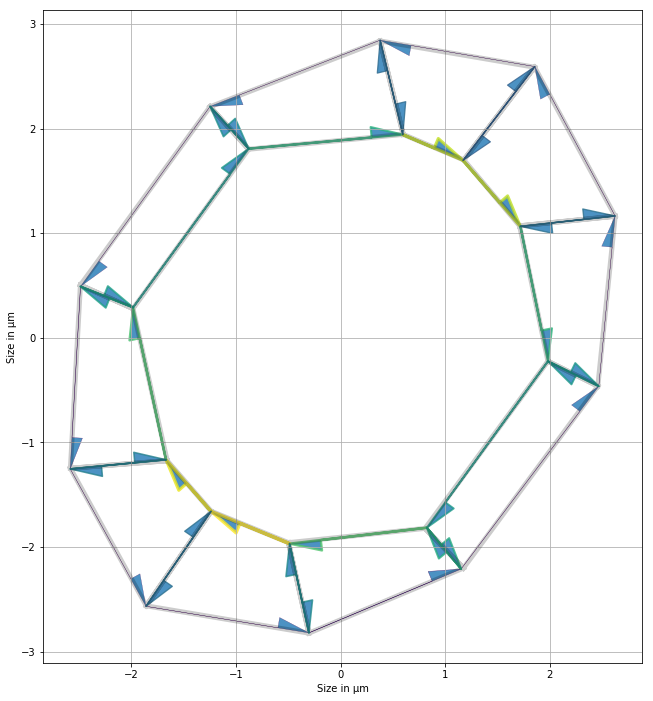

In [8]:
start = time.clock()
copy_psqp_nr_nl = organo.copy()
print('Energy before optimization: ', model.compute_energy(copy_psqp_nr_nl, False))
resc_psqp_nr_nl = adjust_tensions(copy_psqp_nr_nl, initial_guess, {'dic':{}, 'weight':0},
                                  energy_opt, lm_opt, **psqp_opt)
copy_psqp_nr_nl.edge_df.line_tension = prepare_tensions(copy_psqp_nr_nl,resc_psqp_nr_nl['x'])
Solver.find_energy_min(copy_psqp_nr_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(copy_psqp_nr_nl, False))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-resc_psqp_nr_nl['x']),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_psqp_nr_nl, organo)

In [9]:
resc_psqp_nr_nl

{'fun': array([0.00433909]),
 'message': {'text': 'Termination criterion not satisfied, but obtained point is acceptable',
  'value': -6},
 'x': array([ 6.74480263e-02,  8.99877576e-02,  1.24733548e-01,  1.20377032e-01,
         8.86357801e-02,  6.66763039e-02,  7.94997160e-02,  1.13673654e-01,
         1.12798721e-01,  8.17530537e-02,  8.01330494e-04,  8.42074921e-03,
         2.11268621e-03, -4.82246297e-21,  3.94168470e-03,  3.84599835e-06,
         1.62716122e-07, -2.71315241e-21,  7.08934787e-07,  3.75691661e-04,
         6.69103338e-02,  7.62701262e-02,  5.92796811e-02,  4.57537281e-02,
         5.45684285e-02,  7.11652909e-02,  6.27166410e-02,  4.30780062e-02,
         3.80056038e-02,  4.59590708e-02])}

0.0009513847383598291 0.9999873598705645 6.507170285167365e-66


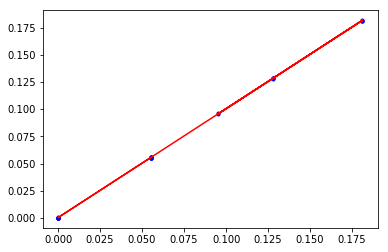

In [13]:
from scipy import stats

var_tens = np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res['x']),
                     np.full(res['x'].shape, organo.edge_df.line_tension[:3*organo.Nf].mean()))

slope, intercept, r_value, p_value, std_err = stats.linregress(organo.edge_df.line_tension.values[:3*Nf] ,res['x'])
print(std_err, r_value, p_value)
plt.plot(organo.edge_df.line_tension.values[:3*Nf],res['x'], 'b.')
plt.plot(organo.edge_df.line_tension.values[:3*Nf], intercept+slope*organo.edge_df.line_tension.values[:3*Nf],
        'r-')

### Without regularization module nor lumen volume
Without the regularization module nor lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

Energy before optimization:  1.2609313349405047
{'norm_factor': 1, 'minimize': {'method': 'L-BFGS-B', 'options': {'disp': False, 'ftol': 1e-06, 'gtol': 0.001}}}
{'norm_factor': 1, 'minimize': {'method': 'L-BFGS-B', 'options': {'gtol': 1e-05, 'ftol': 1e-05}}}
`ftol` termination condition is satisfied.
Function evaluations 852, initial cost 3.9063e+00, final cost 8.0095e-02, first-order optimality 5.86e+02.

Optimization Problem -- Distance minimization problem

        Objective Function: _wrap_obj_and_const

    Objectives:
        Name        Value        Optimum
	  distance           0             0

	Variables (c - continuous, i - integer, d - discrete):
        Name    Type       Value       Lower Bound  Upper Bound
	    L_0       c	      0.065550       0.00e+00     1.00e+06 
	    L_1       c	      0.089968       0.00e+00     1.00e+06 
	    L_2       c	      0.124785       0.00e+00     1.00e+06 
	    L_3       c	      0.120333       0.00e+00     1.00e+06 
	    L_4       c	      0.0

/home/fquinton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


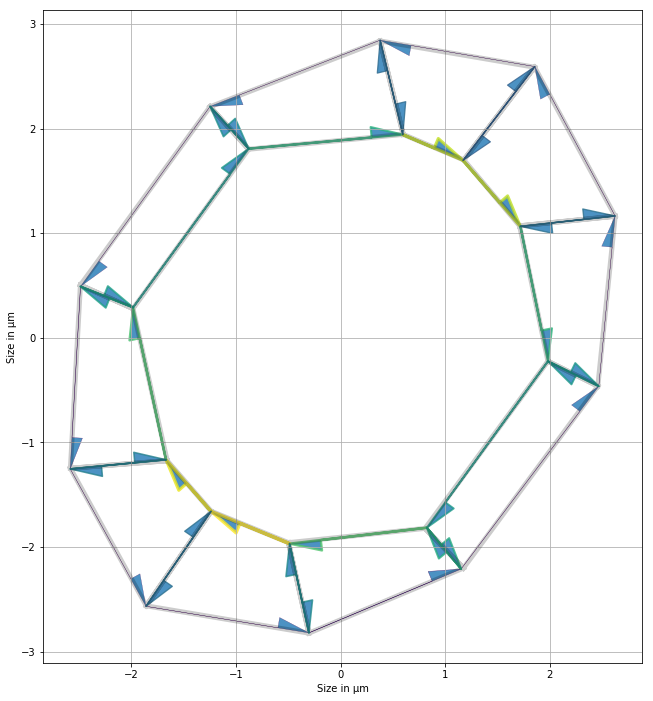

In [14]:
start = time.clock()
copy_psqp_nr_nl = organo.copy()
print('Energy before optimization: ', model.compute_energy(copy_psqp_nr_nl, False))
resc_psqp_nr_nl = adjust_tensions(copy_psqp_nr_nl, initial_guess, {'dic':{}, 'weight':0},
                                  energy_opt, lm_opt, **psqp_opt)
copy_psqp_nr_nl.edge_df.line_tension = prepare_tensions(copy_psqp_nr_nl,resc_psqp_nr_nl['x'])
Solver.find_energy_min(copy_psqp_nr_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(copy_psqp_nr_nl, False))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-resc_psqp_nr_nl['x']),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_psqp_nr_nl, organo)

### With regularization module, without lumen volume
With the regularization module but without lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
start = time.clock()
copy_psqp_r_nl = organo.copy()
resc_psqp_r_nl = adjust_tensions(copy_psqp_r_nl, initial_guess, 
                                {'dic':{'apical' : True, 'basal': True}, 'weight':reg_weight},
                                energy_opt, lm_opt, **psqp_opt)
copy_psqp_r_nl.edge_df.line_tension = prepare_tensions(copy_psqp_r_nl, resc_psqp_r_nl['x'])
Solver.find_energy_min(copy_psqp_r_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-resc_psqp_r_nl['x']),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_psqp_r_nl)

### Without regularization module, with lumen volume
Without the regularization module but with lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
start = time.clock()
copy_psqp_nr_l = organo.copy()
resc_psqp_nr_l = adjust_tensions(copy_psqp_nr_l, np.concatenate((initial_guess, [organo.settings['lumen_volume']])),
                                {'dic':{}, 'weight':0}, energy_opt, lm_opt, **psqp_opt)
copy_psqp_nr_l.edge_df.line_tension = prepare_tensions(copy_psqp_nr_l,resc_psqp_nr_l['x'][:3*organo.Nf])
Solver.find_energy_min(copy_psqp_nr_l, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-resc_psqp_nr_l['x'][:3*organo.Nf]),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_psqp_nr_l)

### With regularization module and with lumen volume
With the regularization module and lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
start = time.clock()
copy_psqp_r_l = organo.copy()
resc_psqp_r_l = adjust_tensions(copy_psqp_r_l, np.concatenate((initial_guess, [organo.settings['lumen_volume']])),
                               {'dic':{'apical' : True, 'basal': True}, 'weight':reg_weight},
                               energy_opt, lm_opt, **psqp_opt) 
copy_psqp_r_l.edge_df.line_tension = prepare_tensions(copy_psqp_r_l,resc_psqp_r_l['x'][:3*organo.Nf])
Solver.find_energy_min(copy_psqp_r_l, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-resc_psqp_r_l['x'][:3*organo.Nf]),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_psqp_r_l)